In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp
import random

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import Store
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = True
C = 15
L = 3

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(Location(20, 40), prime=False))
    customers.append(DoorToDoorCustomer(Location(15, 70), prime=False))
    customers.append(DoorToDoorCustomer(Location(30, 70), prime=True))
    customers.append(DoorToDoorCustomer(Location(80, 60), prime=True))
    customers.append(LockerCustomer(Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(Location(90, 50), prime=False))
    customers.append(LockerCustomer(Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf")))
    for l in range(L):
        stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    for c in range(C):
        if random.random() < ratio_locker_customers:
            customers.append(LockerCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), Customer.get_nearest_store(stores)))
        else:
            if random.random() < ratio_prime_door_to_door_customer:
                customers.append(DoorToDoorCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), prime=True))
            else:
                customers.append(DoorToDoorCustomer(Location(random.randint(0, map_size), random.randint(0, map_size)), prime=False))


In [5]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
s_k = list(filter(lambda customer: type(customer) == DoorToDoorCustomer and customer.prime == False, customers))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(VehicleType.LF, store, math.ceil(0.6 * store.capacity)))


In [6]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])
for sk in s_k:
    S_k_location = np.vstack([S_k_location, [sk.location.x, sk.location.y]])

S_k_location = np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

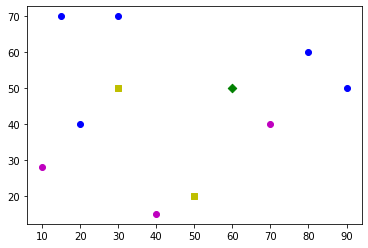

In [7]:
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')